In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

In [20]:
df = pd.read_csv('./data/KAG_energydata_complete.csv')
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [21]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

As seen above, there are no null values in the dataset.

We will remove the 'date' column as it is not needed for our analysis. Having a dataset with temperature, humidity, and other features is sufficient for our energy prediction task.

In [22]:
df = df.drop(columns=['date'])
corr_matrix = df.corr()
X = df.drop(columns=['Appliances'])

Now we study the relevance of the features, before using a Random Forest model to get the feature importance, then with a correlation matrix to see how features are correlated with each other.

In [23]:
from sklearn.ensemble import RandomForestRegressor

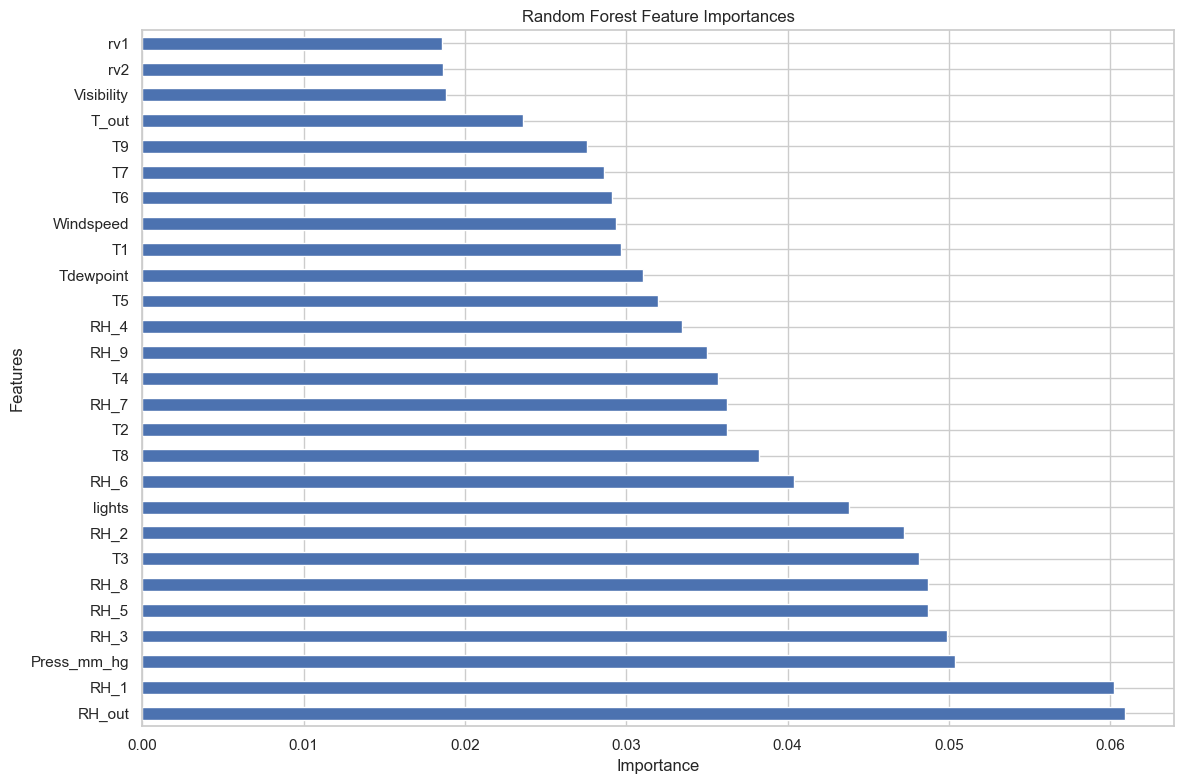

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, df['Appliances'], test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [25]:
cumulative_importance = np.cumsum(feature_importances)
threshold = 0.95
features_to_keep_mask = cumulative_importance <= threshold
important_features = feature_importances[features_to_keep_mask].index.tolist()
all_features = X.columns.tolist()
removed_features = [feature for feature in all_features if feature not in important_features]
removed_features

['Visibility', 'rv1', 'rv2']

As we can see, we can remove features 'Visibility' and random variables.

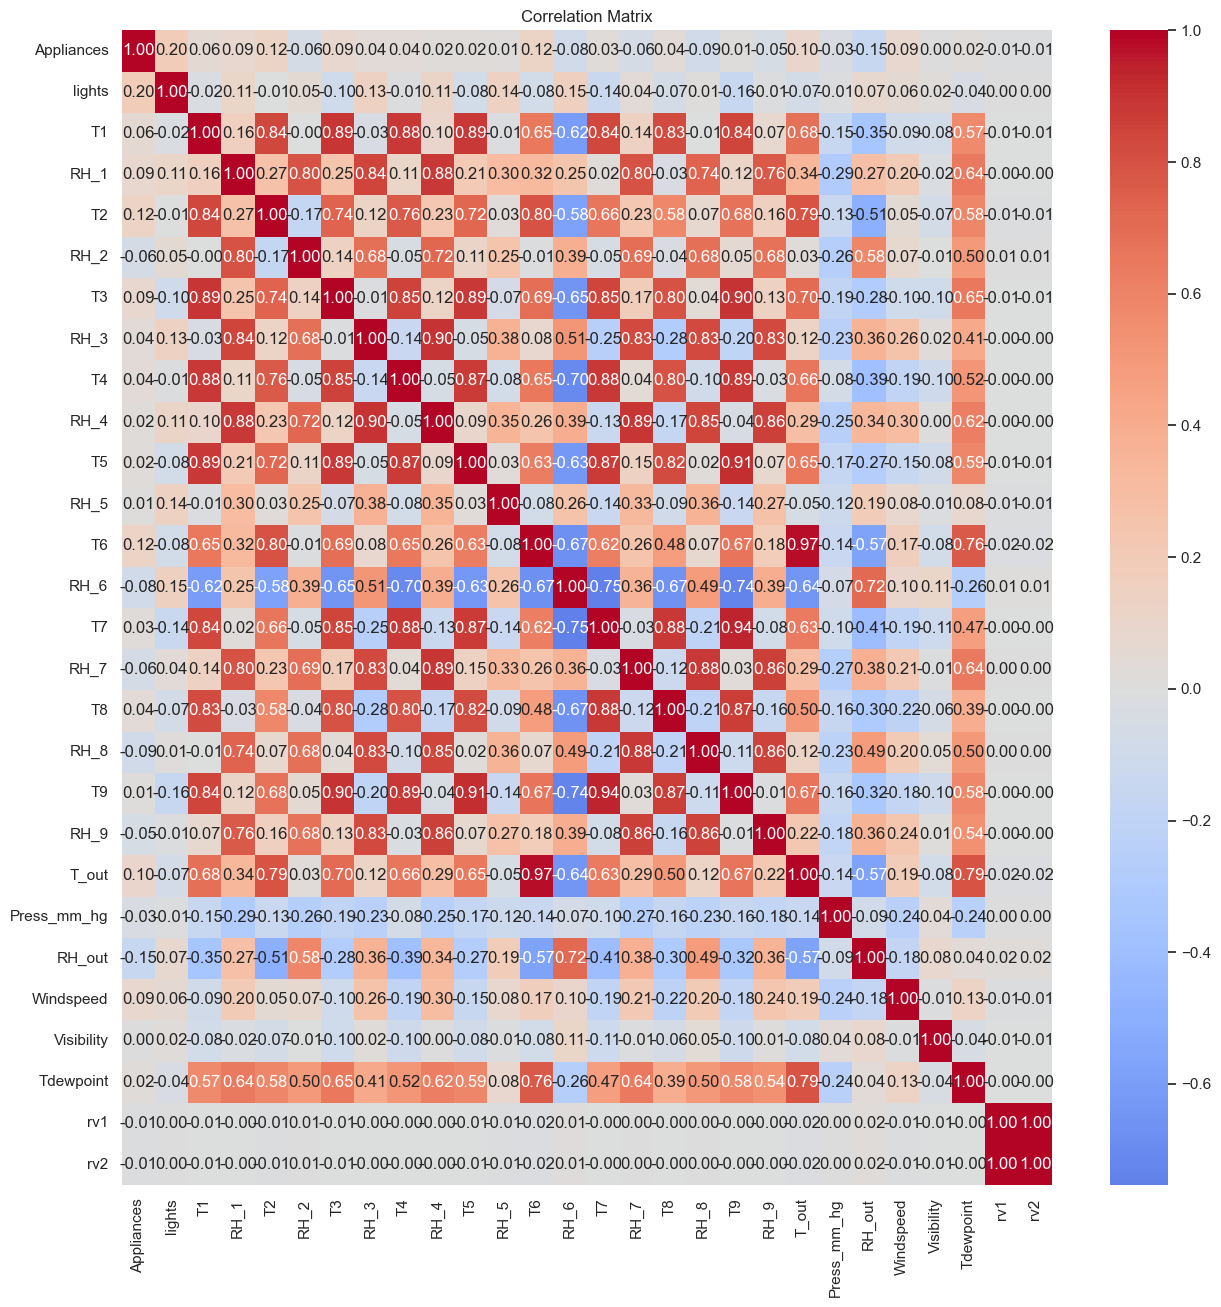

In [26]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [27]:
def get_redundant_pairs(data_frame):
    pairs_to_drop = set()
    cols = data_frame.columns
    for i in range(0, data_frame.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(data_frame, n=100):
    au_corr = data_frame.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data_frame)
    au_corr = au_corr.drop(labels=labels_to_drop)
    sorted_corr = au_corr.sort_values(ascending=False)
    return sorted_corr[:n]


get_top_abs_correlations(df, 40)

rv1   rv2      1.000000
T6    T_out    0.974787
T7    T9       0.944776
T5    T9       0.911055
T3    T9       0.901324
RH_3  RH_4     0.898978
RH_4  RH_7     0.894301
T1    T3       0.892402
T4    T9       0.889439
T3    T5       0.888169
T1    T5       0.885247
RH_7  RH_8     0.883984
T7    T8       0.882123
RH_1  RH_4     0.880359
T4    T7       0.877763
T1    T4       0.877001
T4    T5       0.871813
T5    T7       0.870624
T8    T9       0.869338
RH_7  RH_9     0.858686
RH_4  RH_9     0.856591
RH_8  RH_9     0.855812
T3    T4       0.852778
      T7       0.847374
RH_4  RH_8     0.847259
T1    T9       0.844777
RH_1  RH_3     0.844677
T1    T7       0.838705
      T2       0.836834
RH_3  RH_9     0.833538
      RH_7     0.832685
      RH_8     0.828822
T1    T8       0.825413
T5    T8       0.824981
T2    T6       0.801186
RH_1  RH_7     0.801122
      RH_2     0.797535
T4    T8       0.796256
T3    T8       0.795283
T2    T_out    0.792255
dtype: float64

As we notice from the correlation matrix three rooms are highly correlated to room 'T9', so that we can drop it from the dataset. Both 'T6' and 'T_out' represents external temperature, indeed, they are highly correlated. We will drop 'T_out' as well.

In [28]:
df.drop(columns=['T9', 'T_out', 'rv1', 'rv2', 'Visibility'], inplace=True)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_6,T7,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,84.256667,17.200000,41.626667,18.2,48.900000,45.53,733.5,92.0,7.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,84.063333,17.200000,41.560000,18.2,48.863333,45.56,733.6,92.0,6.666667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,83.156667,17.200000,41.433333,18.2,48.730000,45.50,733.7,92.0,6.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,83.423333,17.133333,41.290000,18.1,48.590000,45.40,733.8,92.0,6.000000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,84.893333,17.200000,41.230000,18.1,48.590000,45.40,733.9,92.0,5.666667,4.9


Now we are ready to split the dataset into training and testing sets. We will use 80% of the data for training and 20% for testing.

In [29]:
train_X, test_X, train_y, test_y = train_test_split(df.drop(columns=['Appliances']), df['Appliances'], test_size=0.2,
                                                    random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sc_train_X = scaler.fit_transform(train_X)
sc_test_X = scaler.transform(test_X)

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

In [32]:
def evaluate_model(m, x_train, y_tr, x_test, y_te):
    m.fit(x_train, y_tr)
    y_pred = m.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")
    print()

for name, model in {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Support Vector Regressor": SVR(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "Extra Trees Regressor": ExtraTreesRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(random_state=42, early_stopping=True, max_iter=1000),
    "XGBoost Regressor": xgb.XGBRegressor(random_state=42)
}.items():
    print("=" * 20)
    print(f"{name}:")
    evaluate_model(model, sc_train_X, train_y, sc_test_X, test_y)

Linear Regression:
RMSE: 91.54
R²:   0.1627

Ridge Regression:
RMSE: 91.54
R²:   0.1627

Lasso Regression:
RMSE: 92.28
R²:   0.1491

ElasticNet Regression:
RMSE: 94.58
R²:   0.1062

Support Vector Regressor:
RMSE: 98.17
R²:   0.0369

Random Forest Regressor:
RMSE: 68.43
R²:   0.5321

Gradient Boosting Regressor:
RMSE: 85.61
R²:   0.2677

Extra Trees Regressor:
RMSE: 62.37
R²:   0.6113

MLP Regressor:
RMSE: 86.78
R²:   0.2475

XGBoost Regressor:
RMSE: 71.43
R²:   0.4902



Between all the models used the Extra Trees Regressor has the best r2 and RMSE. We can use this model for our energy prediction task.

We should consider using the dates in a LSTM model.

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

data = pd.read_csv('./data/KAG_energydata_complete.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data.drop(columns=['Visibility', 'rv1', 'rv2', 'T9', 'T_out'])
sc = StandardScaler()
scaled_data = sc.fit_transform(data)

y_col_index = data.columns.get_loc('Appliances')

def create_sequences(d, n_steps, target_idx):
    """
    Creates sequences of historical data (X) and the corresponding target value (y).
    :param d: The scaled dataset.
    :param n_steps: How many time steps to look back.
    :param target_idx: The column index of the target variable.
    :return: A tuple of numpy arrays (X, y).
    """
    _X, _y = [], []
    for i in range(len(d) - n_steps):
        _X.append(d[i:i + n_steps, :])
        _y.append(d[i + n_steps, target_idx])
    return np.array(_X), np.array(_y)

number_of_steps = 6
lstm_X, lstm_y = create_sequences(scaled_data, number_of_steps, y_col_index)
train_size = int(len(lstm_X) * 0.8)
lstm_X_train, lstm_X_test = lstm_X[:train_size], lstm_X[train_size:]
lstm_y_train, lstm_y_test = lstm_y[:train_size], lstm_y[train_size:]

n_features = lstm_X.shape[2]

model = Sequential([
    LSTM(units=128, activation='relu', input_shape=(number_of_steps, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(units=125, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
history = model.fit(
    lstm_X_train, lstm_y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

lstm_y_pred_scaled = model.predict(lstm_X_test)

dummy_pred = np.zeros((len(lstm_y_pred_scaled), n_features))
dummy_pred[:, y_col_index] = lstm_y_pred_scaled.ravel()
lstm_y_pred = sc.inverse_transform(dummy_pred)[:, y_col_index]

dummy_test = np.zeros((len(lstm_y_test), n_features))
dummy_test[:, y_col_index] = lstm_y_test.ravel()
lstm_y_test_unscaled = sc.inverse_transform(dummy_test)[:, y_col_index]

lstm_rmse = np.sqrt(mean_squared_error(lstm_y_test_unscaled, lstm_y_pred))
lstm_r2 = r2_score(lstm_y_test_unscaled, lstm_y_pred)


print("\n--- Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.2f} Wh")
print(f"R-squared (R2 Score): {lstm_r2:.4f}")


C:\Users\Enrico\IdeaProjects\AppliancesEnergyPrediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 6, 128)         │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 125)            │       127,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,953 (831.85 KB)

 Trainable params: 212,953 (831.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7979 - val_loss: 0.3747
Epoch 2/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4907 - val_loss: 0.3537
Epoch 3/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4702 - val_loss: 0.3286
Epoch 4/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5017 - val_loss: 0.3278
Epoch 5/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4870 - val_loss: 0.3236
Epoch 6/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4587 - val_loss: 0.3063
Epoch 7/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4274 - val_loss: 0.3023
Epoch 8/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4233 - val_loss: 0.3316
Epoch 9/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4301 - val_loss: 0.3178
Epoch 10/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4045 - val_loss: 0.3155
Epoch 11/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4466 - val_loss: 0.3510
Epoch 12/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

As we can see, LSTM model has higer RMSE and lower R² score than Extra Trees Regressor. We can use the Extra Trees Regressor for our energy prediction task.

# Parameter Tuning

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 80, 150, 200, 250],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(ExtraTreesRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=2)
grid_search.fit(sc_train_X, train_y)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 90 candidates, totalling 270 fits


In [35]:
pred_y = best_model.predict(sc_test_X)
mse = mean_squared_error(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"R²: {r2_score(test_y, pred_y):.4f}")
print(grid_search.best_params_)

MAE: 26.6421
MSE: 3447.6623
RMSE: 58.7168
R²: 0.6555
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


In [36]:
from sklearn.model_selection import cross_validate
model = ExtraTreesRegressor(max_features='sqrt', min_samples_split= 2, n_estimators= 300, random_state=42)
scoring = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(model, sc_train_X, train_y, cv=10, scoring=scoring, return_train_score=True, n_jobs=4)

In [37]:
print(f"R2: {cv_results['test_r2'].mean():.4f}")
print(f"RMSE: {-cv_results['test_rmse'].mean():.4f}")
print(f"MAE: {-cv_results['test_mae'].mean():.4f}")
print(f"MSE: {-cv_results['test_mse'].mean():.4f}")

R2: 0.6059
RMSE: 64.4882
MAE: 29.3460
MSE: 4178.3671


## Observations

1. The best parameters for the Extra Trees Regressor are: 'max_depth': None, max_features': 'sqrt', min_samples_split': 2, 'n_estimators': 300.
2. The model has an RMSE of 60.486 which indicates an improvement over 63.77 achieved using untuned model.
3. The R² score is 0.634, over 0.593 achieved using untuned model.